<a href="https://colab.research.google.com/github/gmit22/LifeHack-2020/blob/master/Image_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.utils import shuffle
import imutils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file = open("/content/drive/My Drive/LifeHack/data.txt", "w")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dir = os.path.join(os.getcwd(), "drive/My Drive/data")

In [ ]:
def loadData(dir):

    images = []
    category = []
    file_dir = []

    for img in os.listdir(dir):

        if img.endswith(".png"):
        #images.append(cv2.imread(os.path.join(dir, img)))
            file_dir.append(os.path.join(dir, img))

            if img.startswith('NL'):      #assigning label to file according to          
                category.append(0)             # their type

            elif img.startswith('ca'):    
                category.append(1)

            elif img.startswith('Gl'):  
                category.append(2)

            elif img.startswith('Re'):          
                category.append(3)

    file_dir = np.array(file_dir)
    category = np.array(category, dtype = 'int32')  

    return shuffle(file_dir, category,random_state=817328462)


In [ ]:
file_dir, category = loadData(dir)

In [ ]:
print(len(file_dir))

601


In [ ]:
def get_label(encoded_val):
      
      labels = {0:'normal', 1:'cataract', 2:'glaucoma', 3:'retina'}
      return labels[class_code]

In [ ]:
def data_augment(file_dir, labels):

    img_set = []
    lbl_set = []

    for i in range(len(file_dir)):

        if i%100==0:
            print(i)
        label = labels[i]
        img = get_object(file_dir[i])

        img_b = img + 0.07*img
        img_d = img - 0.07*img

        flip_v_b = cv2.flip(img_b,0)
        flip_h_b = cv2.flip(img_b,1)

        flip_v_d = cv2.flip(img_d,0)
        flip_h_d = cv2.flip(img_d,1)

        flip_v = cv2.flip(img,0) #vertical flip
        flip_h = cv2.flip(img,1) #lr flip

        img_set.append(img)
        # img_set.append(img_b)
        # img_set.append(img_d)
        img_set.append(flip_v)
        img_set.append(flip_h)
        img_set.append(flip_v_b)
        img_set.append(flip_h_b)
        img_set.append(flip_v_d)
        img_set.append(flip_h_d)

        # lbl_set.append(label)
        # lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
        lbl_set.append(label)
    print('Done')
    return np.array(img_set),np.array(lbl_set)


In [ ]:
def get_object(filename):

    image = cv2.imread(filename)
    im_size = 256
    
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY) # convert 2 grayscale

    retval, threshold = cv2.threshold(gray,10,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(threshold,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) # find contours

    # ensure at least some circles were found
    if contours:

        contours = sorted(contours, key=cv2.contourArea, reverse=True) 

        #find the bounding rect
        x,y,w,h = cv2.boundingRect(contours[0])                  
        img = image[y:y+h,x:x+w]# crop image

        resize=cv2.resize(img,(im_size,im_size)) # resize to im_size X im_size size
        
        return resize

    return cv2.resize(image, (im_size,im_size))

In [ ]:
X, y = data_augment(file_dir, category)

0
100
200
300
400
500
600
Done


CNN model

In [ ]:
import keras
y = keras.utils.to_categorical(y, 4)
X = X.astype('float32')
X /= 255

Using TensorFlow backend.


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

In [ ]:
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import keras

To visualize results

In [ ]:
def visualize_results(history):

    # Plot the accuracy and loss curves
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.title('Training and validation loss')
    
    plt.legend()
    plt.show()

Creating model using Keras

Model 1

In [ ]:
model = keras.Sequential()

#number of filters(patterns to be detected), window size 
model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(256,256,3)))
model.add(Conv2D(32, (3,3), activation='relu'))

#Scales down, by discarding less useful data
model.add(MaxPooling2D(pool_size=(2, 2)))

#Prevents memorizing of datapoint sets
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()
##compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

#train the model
trained_model = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=20, #number of iterations
    validation_data=(X_val, y_val),
    shuffle=True     
)
# from pathlib import Path
# #save the neural network structure
# model_structure = model.to_json()
# f = Path("model_structure.json")
# f.write_text(model_structure)

# #Save the network's trained weights
# model.save_weights("model_weights.h5")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 516128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               66064512  
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
print(f'The model accuracy is {accuracy}')

1052/1052 [==============================] - 1s 1ms/step
The model accuracy is 0.6378327012062073


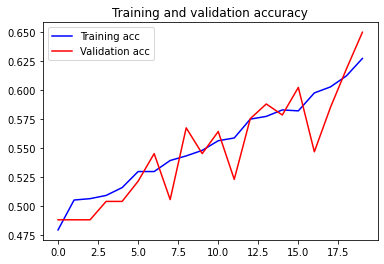

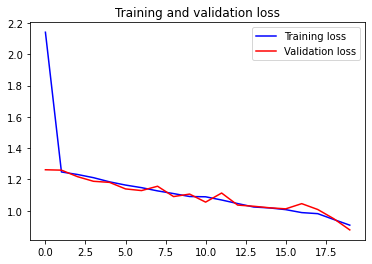

In [ ]:
visualize_results(trained_model)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

Model 2


In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.summary()
# train the model on the new data for a few epochs
trained_model_1 = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=16, #number of iterations
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/16
79/79 [==============================] - 8s 104ms/step - loss: 1.7095 - accuracy: 0.5040 - val_loss: 0.8845 - val_accuracy: 0.6403
Epoch 2/16
79/79 [==============================] - 6s 80ms/step - loss: 1.0166 - accuracy: 0.6010 - val_loss: 0.9600 - val_accuracy: 0.5959
Epoch 3/16
79/79 [==============================] - 6s 80ms/step - loss: 0.8870 - accuracy: 0.6462 - val_loss: 0.7874 - val_accuracy: 0.6815
Epoch 4/16
79/79 [==============================] - 6s 81ms/step - loss: 0.8106 - accuracy: 0.6747 - val_loss: 1.1453 - val_accuracy: 0.6054
Epoch 5/16
79/79 [==============================] - 6s 81ms/step - loss: 0.7485 - accuracy: 0.7048 - val_loss: 0.7887 - val_accuracy: 0.6704
Epoch 6/16
79/79 [==============================] - 6s 80ms/step - loss: 0.6771 - accuracy: 0.7242 - val_loss: 0.8939 - val_accuracy: 0.6513
Epoch 7/16
79/79 [==============================] - 6s 80ms/step - loss: 0.6561 - accuracy: 0.7429 - val_loss: 0.6805 - val_accuracy: 0.7116
Epoch 8/16
7

33/33 [==============================] - 2s 62ms/step - loss: 0.5182 - accuracy: 0.8213
The model accuracy is 0.8212927579879761


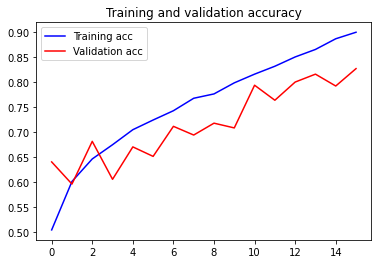

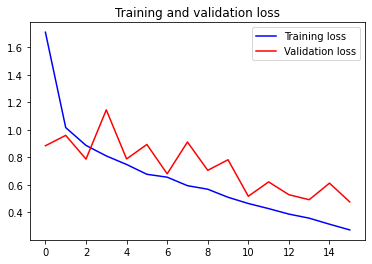

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
print(f'The model accuracy is {accuracy}')
visualize_results(trained_model_1)

In [ ]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True


# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

trained_model_2 = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=16, #number of iterations
    validation_data=(X_val, y_val),
    shuffle=True
)

Epoch 1/16
79/79 [==============================] - 9s 111ms/step - loss: 1.2039 - accuracy: 0.4952 - val_loss: 1.1769 - val_accuracy: 0.4992
Epoch 2/16
79/79 [==============================] - 7s 94ms/step - loss: 1.0271 - accuracy: 0.5836 - val_loss: 1.0538 - val_accuracy: 0.5563
Epoch 3/16
79/79 [==============================] - 7s 94ms/step - loss: 0.9213 - accuracy: 0.6177 - val_loss: 0.9462 - val_accuracy: 0.5975
Epoch 4/16
79/79 [==============================] - 7s 94ms/step - loss: 0.8538 - accuracy: 0.6525 - val_loss: 0.8755 - val_accuracy: 0.6545
Epoch 5/16
79/79 [==============================] - 7s 94ms/step - loss: 0.7775 - accuracy: 0.6953 - val_loss: 0.8152 - val_accuracy: 0.6783
Epoch 6/16
79/79 [==============================] - 7s 94ms/step - loss: 0.7153 - accuracy: 0.7322 - val_loss: 0.7661 - val_accuracy: 0.7116
Epoch 7/16
79/79 [==============================] - 7s 94ms/step - loss: 0.6540 - accuracy: 0.7599 - val_loss: 0.7176 - val_accuracy: 0.7338
Epoch 8/16
7

In [ ]:
prediction = model.predict(X)

Predict classes, and check actual values

In [ ]:
import random
for i in range(30):
    index = random.randint(0, 500)
    print(y[index], prediction[index])

33/33 [==============================] - 2s 62ms/step - loss: 0.4276 - accuracy: 0.8650
The model accuracy is 0.8650190234184265


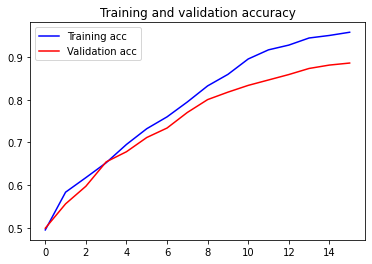

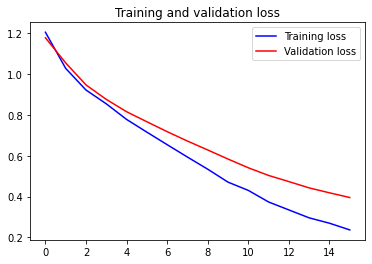

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
print(f'The model accuracy is {accuracy}')
visualize_results(trained_model_2)

In [ ]:
from sklearn.metrics import confusion_matrix
Y_pred_classes = np.argmax(prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


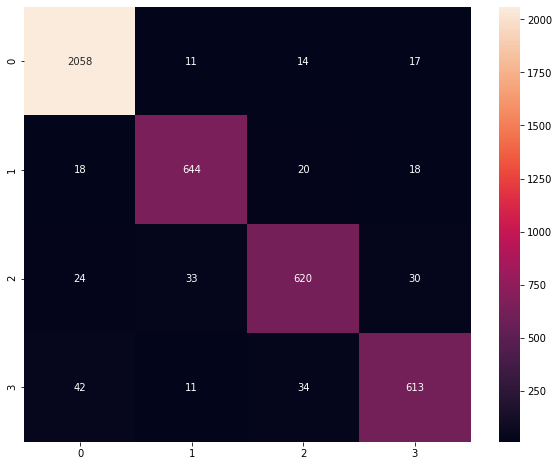

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d")